### Imports:

In [1]:
import sys 
sys.path.append("GradCAM-Dataset/")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2 
import torch
from torch import nn
import torch.nn.functional as F

from torch.utils.data import DataLoader,Dataset
from torchvision import datasets,transforms

from tqdm.notebook import tqdm
import albumentations as A
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import utils

### Config

In [3]:
device = "cuda" if torch.cuda.is_available else "cpu"
device

'cuda'

In [4]:
CSV_File = r"C:\Users\rahul\python\Machine learning\GradCAM-Dataset\train.csv"
Data_dir = r"C:\Users\rahul\python\Machine learning\GradCAM-Dataset"

Batch_size = 16
lr = 0.001
Epochs = 50


In [5]:
data = pd.read_csv(CSV_File)
data.head()

,img_path,label
0,train_images/mushroom_51.jpg,2
1,train_images/eggplant_37.jpg,1
2,train_images/mushroom_20.jpg,2
3,train_images/eggplant_51.jpg,1
4,train_images/eggplant_26.jpg,1


In [6]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=42)

label_class = {
    0:"cucumber",
    1:"eggplant",
    2:"mushroom"
}

### Augmentations:

In [7]:
train_augs = A.Compose([
    A.Rotate(),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
])

valid_augs = A.Compose([
    A.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
])

### Load data:

In [8]:
import os
class CustomData(Dataset):
    def __init__(self,df,Data_dir,augs):
        self.data_dir = Data_dir
        self.augs = augs
        self.df = df
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        img_path = os.path.join(Data_dir,self.df.img_path.iloc[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        label = self.df.iloc[idx].label
        
        if self.augs:
            data = self.augs(image = img)
            img = data['image']

        img = torch.from_numpy(img).permute(2, 0, 1)

        return img, label

In [9]:
trainset = CustomData(X_train,Data_dir,train_augs)
validset = CustomData(X_test,Data_dir,valid_augs)

### Data Visualization:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


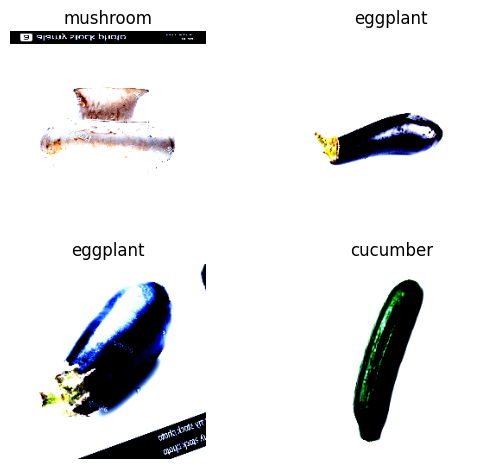

In [10]:
def plot_data(n_rows,n_cols,dataset,rand_state = None):
    if rand_state: 
        torch.cuda.manual_seed(rand_state)
        torch.manual_seed(rand_state)
    rand_idx = torch.randint(0,len(dataset),size = [n_rows*n_cols])
    for i,idx in enumerate(rand_idx):
        image,label = dataset[idx.item()]
        plt.subplot(n_rows,n_cols,i+1)
        plt.imshow(image.permute(1,2,0))
        plt.title(label_class[label])
        plt.axis(False)
    plt.tight_layout()
    
plot_data(2,2,trainset)

### Data_loader:

In [11]:
trainloader = DataLoader(trainset,batch_size=Batch_size,shuffle=True)
validloader = DataLoader(validset,batch_size=Batch_size,shuffle=False) 

In [12]:
print(f"The length of Train loader is {len(trainloader)}")
print(f"The length of Valid loader is {len(validloader)}")

The length of Train loader is 10
The length of Valid loader is 3


In [13]:
for image,label in trainloader:
    break

print(f"One img_batch size is : {image.shape}")
print(f"One label_batch size is:  {label.shape}")

One img_batch size is : torch.Size([16, 3, 227, 227])
One label_batch size is:  torch.Size([16])


### Model:

In [14]:
class ImageModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.feature_extractor  = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=16,kernel_size=5,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4,stride=2),
            
            nn.Conv2d(in_channels=16,out_channels=16,kernel_size=5,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4,stride=2),
            
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=5,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4,stride=2),
            
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=5,padding=1),
            nn.ReLU()    
        )
        self.maxpool = nn.MaxPool2d(kernel_size=4,stride=2)
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(6400,2048),
            nn.ReLU(),
            nn.Linear(2048,3)
        )
        
        self.gradient = None
        
    def activation_hook(self,grad):
        self.gradient = grad
        
    def forward(self,X):
        X = self.feature_extractor(X)
        
        h = X.register_hook(self.activation_hook)
        X = self.maxpool(X)
        X = self.classifier(X)
        
        return X
    
    def get_activation_gradients(self):
        return self.gradient
    
    def get_activations(self,X):
        return self.feature_extractor(X)
    

In [15]:
mymodel = ImageModel().to(device)

def initialize_weights(model, init_function):
    for name, param in model.named_parameters():
        if 'weight' in name:
            init_function(param)

initialize_weights(mymodel, nn.init.xavier_uniform_)

In [16]:
from torchsummary import summary
image.shape
sample = torch.randn(size = [3,227,227])
print(summary(model=mymodel,input_size=sample.shape,batch_size=16,device=device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [16, 16, 225, 225]           1,216
              ReLU-2         [16, 16, 225, 225]               0
         MaxPool2d-3         [16, 16, 111, 111]               0
            Conv2d-4         [16, 16, 109, 109]           6,416
              ReLU-5         [16, 16, 109, 109]               0
         MaxPool2d-6           [16, 16, 53, 53]               0
            Conv2d-7           [16, 32, 51, 51]          12,832
              ReLU-8           [16, 32, 51, 51]               0
         MaxPool2d-9           [16, 32, 24, 24]               0
           Conv2d-10           [16, 64, 22, 22]          51,264
             ReLU-11           [16, 64, 22, 22]               0
        MaxPool2d-12           [16, 64, 10, 10]               0
          Flatten-13                 [16, 6400]               0
           Linear-14                 [1

### Create Train and Eval function:

In [17]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mymodel.parameters(),lr=lr)
optimizer,loss_fn

(Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.001
     maximize: False
     weight_decay: 0
 ),
 CrossEntropyLoss())

In [18]:
## loss_list:
train_loss_list = []
valid_loss_list = []
## Accuracy_list:
train_acc_list = []
valid_acc_list = []

In [19]:
def train_step(model,dataloader,optimizer,loss_fn):
    total_loss,total_acc = 0,0
    model.train()
    for images,labels in tqdm(dataloader):
        images,labels = images.to(device),labels.to(device)

        # optimizer zero grad:
        optimizer.zero_grad()

        # forward pass:
        logits = model(images)
        pred = nn.Softmax(dim=1)(logits).argmax(dim=1)

        # loss calculation:
        loss = loss_fn(logits.squeeze(),labels)
        total_loss += loss.item()
        acc = (pred == labels).sum().item()
        total_acc += acc

        # backward pass:
        loss.backward()

        # optimizer update:
        optimizer.step()

    total_loss /= len(dataloader)
    total_acc /= len(dataloader)
    
    ## loss & accuracy collection:
    train_loss_list.append(total_loss)
    train_acc_list.append(total_acc)
    
    print(f"Train loss :  {total_loss:.2f}| Train accuracy : {total_acc:.2f}")

In [20]:
def eval_step(model,dataloader):
    total_loss,total_acc = 0,0
    model.eval()
    for images,labels in (dataloader):
        images,labels = images.to(device),labels.to(device)

        # forward pass:
        logits = model(images)
        pred = nn.Softmax(dim=1)(logits).argmax(dim=1)

        # loss calculation:
        loss = loss_fn(logits.squeeze(),labels)
        total_loss += loss.item()
        acc = (pred == labels).sum().item()
        total_acc += acc

    total_loss /= len(dataloader)
    total_acc /= len(dataloader)
    
    ## loss & accuracy collection:
    valid_loss_list.append(total_loss)
    valid_acc_list.append(total_acc)
    
    print(f"Validation loss :  {total_loss:.2f}| Validation accuracy : {total_acc:.2f}")

### Train loop:

In [21]:
for epoch in (range(Epochs)):
    print(f"Epoch __ {epoch}")
    train_step(mymodel,trainloader,optimizer,loss_fn)
    eval_step(mymodel,validloader)
    print()

Epoch __ 0


  0%|          | 0/10 [00:00<?, ?it/s]

Train loss :  3.03| Train accuracy : 5.00
Validation loss :  0.97| Validation accuracy : 8.33

Epoch __ 1


  0%|          | 0/10 [00:00<?, ?it/s]

Train loss :  1.01| Train accuracy : 8.50
Validation loss :  0.85| Validation accuracy : 8.00

Epoch __ 2


  0%|          | 0/10 [00:00<?, ?it/s]

Train loss :  0.70| Train accuracy : 9.90
Validation loss :  0.69| Validation accuracy : 8.33

Epoch __ 3


  0%|          | 0/10 [00:00<?, ?it/s]

Train loss :  0.52| Train accuracy : 12.10
Validation loss :  0.34| Validation accuracy : 10.33

Epoch __ 4


  0%|          | 0/10 [00:00<?, ?it/s]

Train loss :  0.31| Train accuracy : 12.90
Validation loss :  0.62| Validation accuracy : 11.00

Epoch __ 5


  0%|          | 0/10 [00:00<?, ?it/s]

Train loss :  0.25| Train accuracy : 13.50
Validation loss :  0.36| Validation accuracy : 11.00

Epoch __ 6


  0%|          | 0/10 [00:00<?, ?it/s]

Train loss :  0.27| Train accuracy : 13.30
Validation loss :  0.26| Validation accuracy : 11.00

Epoch __ 7


  0%|          | 0/10 [00:00<?, ?it/s]

Train loss :  0.34| Train accuracy : 13.70
Validation loss :  0.31| Validation accuracy : 10.67

Epoch __ 8


  0%|          | 0/10 [00:00<?, ?it/s]

Train loss :  0.24| Train accuracy : 13.40
Validation loss :  0.18| Validation accuracy : 11.33

Epoch __ 9


  0%|          | 0/10 [00:00<?, ?it/s]

Train loss :  0.23| Train accuracy : 13.60
Validation loss :  0.34| Validation accuracy : 11.33

Epoch __ 10


  0%|          | 0/10 [00:00<?, ?it/s]

Train loss :  0.16| Train accuracy : 13.70
Validation loss :  0.13| Validation accuracy : 12.00

Epoch __ 11


  0%|          | 0/10 [00:00<?, ?it/s]

Train loss :  0.24| Train accuracy : 13.80
Validation loss :  0.18| Validation accuracy : 12.00

Epoch __ 12


  0%|          | 0/10 [00:00<?, ?it/s]

Train loss :  0.15| Train accuracy : 14.10
Validation loss :  0.22| Validation accuracy : 11.67

Epoch __ 13


  0%|          | 0/10 [00:00<?, ?it/s]

Train loss :  0.23| Train accuracy : 13.50
Validation loss :  0.63| Validation accuracy : 11.67

Epoch __ 14


  0%|          | 0/10 [00:00<?, ?it/s]

Train loss :  0.14| Train accuracy : 14.20
Validation loss :  0.07| Validation accuracy : 12.00

Epoch __ 15


  0%|          | 0/10 [00:00<?, ?it/s]

Train loss :  0.12| Train accuracy : 14.30
Validation loss :  0.11| Validation accuracy : 12.33

Epoch __ 16


  0%|          | 0/10 [00:00<?, ?it/s]

Train loss :  0.14| Train accuracy : 13.70
Validation loss :  0.07| Validation accuracy : 12.00

Epoch __ 17


  0%|          | 0/10 [00:00<?, ?it/s]

Train loss :  0.07| Train accuracy : 14.40
Validation loss :  0.10| Validation accuracy : 12.00

Epoch __ 18


  0%|          | 0/10 [00:00<?, ?it/s]

Train loss :  0.04| Train accuracy : 14.60
Validation loss :  0.51| Validation accuracy : 11.33

Epoch __ 19


  0%|          | 0/10 [00:00<?, ?it/s]

Train loss :  0.03| Train accuracy : 14.50
Validation loss :  0.00| Validation accuracy : 12.67

Epoch __ 20


  0%|          | 0/10 [00:00<?, ?it/s]

Train loss :  0.41| Train accuracy : 14.10
Validation loss :  0.09| Validation accuracy : 12.33

Epoch __ 21


  0%|          | 0/10 [00:00<?, ?it/s]

Train loss :  0.52| Train accuracy : 12.30
Validation loss :  0.53| Validation accuracy : 9.67

Epoch __ 22


  0%|          | 0/10 [00:00<?, ?it/s]

Train loss :  0.26| Train accuracy : 13.40
Validation loss :  0.11| Validation accuracy : 12.33

Epoch __ 23


  0%|          | 0/10 [00:00<?, ?it/s]

Train loss :  0.09| Train accuracy : 14.20
Validation loss :  0.62| Validation accuracy : 11.67

Epoch __ 24


  0%|          | 0/10 [00:00<?, ?it/s]

Train loss :  0.29| Train accuracy : 14.00
Validation loss :  0.13| Validation accuracy : 12.00

Epoch __ 25


  0%|          | 0/10 [00:00<?, ?it/s]

Train loss :  0.06| Train accuracy : 14.30
Validation loss :  0.19| Validation accuracy : 11.67

Epoch __ 26


  0%|          | 0/10 [00:00<?, ?it/s]

Train loss :  0.05| Train accuracy : 14.50
Validation loss :  0.32| Validation accuracy : 11.67

Epoch __ 27


  0%|          | 0/10 [00:00<?, ?it/s]

Train loss :  0.04| Train accuracy : 14.60
Validation loss :  0.43| Validation accuracy : 11.67

Epoch __ 28


  0%|          | 0/10 [00:00<?, ?it/s]

Train loss :  0.09| Train accuracy : 14.30
Validation loss :  0.14| Validation accuracy : 11.67

Epoch __ 29


  0%|          | 0/10 [00:00<?, ?it/s]

Train loss :  0.13| Train accuracy : 14.30
Validation loss :  0.05| Validation accuracy : 12.33

Epoch __ 30


  0%|          | 0/10 [00:00<?, ?it/s]

Train loss :  0.09| Train accuracy : 14.70
Validation loss :  0.05| Validation accuracy : 12.33

Epoch __ 31


  0%|          | 0/10 [00:00<?, ?it/s]

Train loss :  0.09| Train accuracy : 14.60
Validation loss :  0.10| Validation accuracy : 12.33

Epoch __ 32


  0%|          | 0/10 [00:00<?, ?it/s]

Train loss :  0.06| Train accuracy : 14.60
Validation loss :  0.04| Validation accuracy : 12.33

Epoch __ 33


  0%|          | 0/10 [00:00<?, ?it/s]

Train loss :  0.02| Train accuracy : 14.70
Validation loss :  0.04| Validation accuracy : 12.33

Epoch __ 34


  0%|          | 0/10 [00:00<?, ?it/s]

Train loss :  0.09| Train accuracy : 14.60
Validation loss :  0.33| Validation accuracy : 12.00

Epoch __ 35


  0%|          | 0/10 [00:00<?, ?it/s]

Train loss :  0.15| Train accuracy : 14.40
Validation loss :  0.12| Validation accuracy : 12.00

Epoch __ 36


  0%|          | 0/10 [00:00<?, ?it/s]

Train loss :  0.16| Train accuracy : 14.00
Validation loss :  0.05| Validation accuracy : 12.33

Epoch __ 37


  0%|          | 0/10 [00:00<?, ?it/s]

Train loss :  0.14| Train accuracy : 14.00
Validation loss :  0.21| Validation accuracy : 12.00

Epoch __ 38


  0%|          | 0/10 [00:00<?, ?it/s]

Train loss :  0.11| Train accuracy : 14.10
Validation loss :  0.06| Validation accuracy : 12.33

Epoch __ 39


  0%|          | 0/10 [00:00<?, ?it/s]

Train loss :  0.10| Train accuracy : 14.20
Validation loss :  0.24| Validation accuracy : 11.67

Epoch __ 40


  0%|          | 0/10 [00:00<?, ?it/s]

Train loss :  0.18| Train accuracy : 14.40
Validation loss :  0.05| Validation accuracy : 12.33

Epoch __ 41


  0%|          | 0/10 [00:00<?, ?it/s]

Train loss :  0.23| Train accuracy : 14.20
Validation loss :  0.38| Validation accuracy : 12.00

Epoch __ 42


  0%|          | 0/10 [00:00<?, ?it/s]

Train loss :  0.47| Train accuracy : 14.10
Validation loss :  0.22| Validation accuracy : 11.67

Epoch __ 43


  0%|          | 0/10 [00:00<?, ?it/s]

Train loss :  0.19| Train accuracy : 14.30
Validation loss :  0.34| Validation accuracy : 11.33

Epoch __ 44


  0%|          | 0/10 [00:00<?, ?it/s]

Train loss :  0.22| Train accuracy : 14.10
Validation loss :  0.25| Validation accuracy : 11.00

Epoch __ 45


  0%|          | 0/10 [00:00<?, ?it/s]

Train loss :  0.48| Train accuracy : 14.00
Validation loss :  0.19| Validation accuracy : 11.33

Epoch __ 46


  0%|          | 0/10 [00:00<?, ?it/s]

Train loss :  0.35| Train accuracy : 13.70
Validation loss :  0.71| Validation accuracy : 11.00

Epoch __ 47


  0%|          | 0/10 [00:00<?, ?it/s]

Train loss :  0.36| Train accuracy : 12.80
Validation loss :  0.38| Validation accuracy : 10.67

Epoch __ 48


  0%|          | 0/10 [00:00<?, ?it/s]

Train loss :  0.50| Train accuracy : 12.50
Validation loss :  0.24| Validation accuracy : 11.33

Epoch __ 49


  0%|          | 0/10 [00:00<?, ?it/s]

Train loss :  0.25| Train accuracy : 13.90
Validation loss :  0.13| Validation accuracy : 12.00



Text(0.5, 1.0, 'Loss Plot')

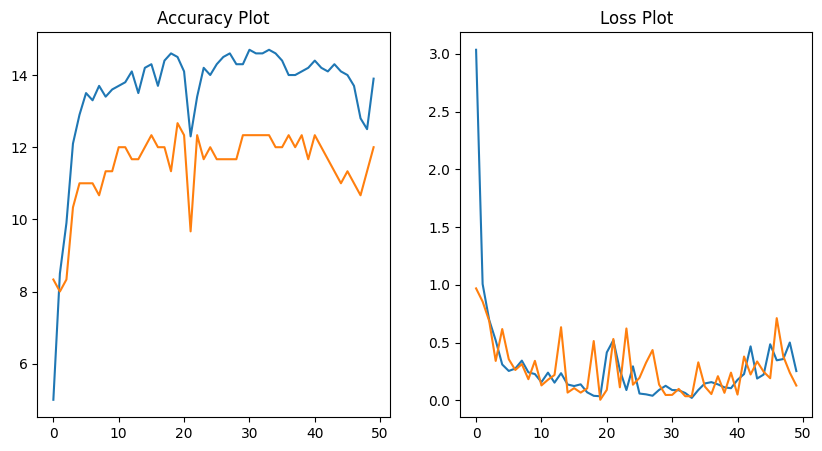

In [22]:
plt.figure(figsize=[10,5])
plt.subplot(1,2,1)
plt.plot(range(Epochs),train_acc_list)
plt.plot(range(Epochs),valid_acc_list)
plt.title("Accuracy Plot")

plt.subplot(1,2,2)
plt.plot(range(Epochs),train_loss_list)
plt.plot(range(Epochs),valid_loss_list)
plt.title("Loss Plot")

### Grad-Cam:

In [23]:
def grad_Cam(model,image,label,size):
    
    label.backward()
    gradients = model.get_activation_gradients()
    pooled_gradients = torch.mean(gradients,dim=(0,2,3))
    activations = model.get_activations(image.to(device)).detach()
    
    for i in range(pooled_gradients.shape[0]):
        activations[:,i,:,:] *= pooled_gradients[i]
        
    heatmap = torch.mean(activations,dim = 1).squeeze().cpu()
    heatmap = nn.ReLU()(heatmap)
    heatmap /= torch.max(heatmap)
    heatmap = cv2.resize(heatmap.numpy(),(size,size))
    
    return heatmap

In [24]:
class_label = {
    'cucumber':0,
    'eggplant':1,
    'mushroom':2
}

In [25]:
rand_idx = torch.randint(0,len(validset),size=[1]).item()

In [26]:
def plot_results(denorm_img,label_class,pred,heatmap,class_=None):
    plt.figure(figsize=[12,2])
    plt.subplot(1,3,1)
    plt.imshow(denorm_img)
    plt.axis(False)
    plt.title(label_class[label])
    
    plt.subplot(1,3,2)
    soft_pred = nn.Softmax(dim=1)(pred)
    plt.barh(y=list(label_class.values()),width=soft_pred[0].detach().cpu().numpy())
    plt.title(f"Selected : {class_} | Original : {label_class[label]}")

    plt.subplot(1,3,3)
    plt.imshow(denorm_img)
    plt.imshow(heatmap,alpha=0.7,cmap="coolwarm")
    plt.axis(False)
    plt.title("Heatmap")
    plt.tight_layout()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

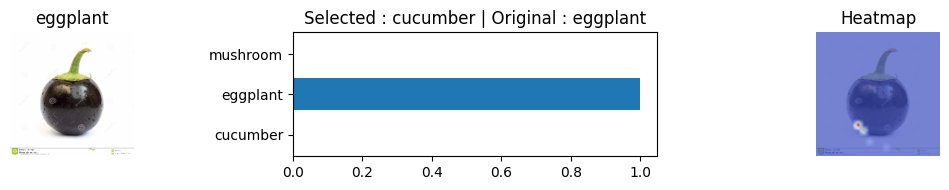

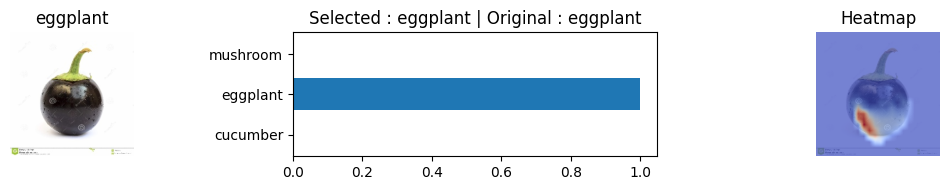

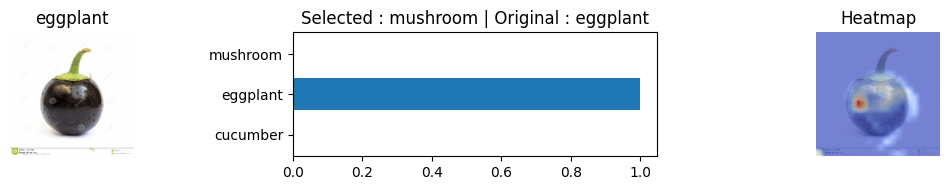

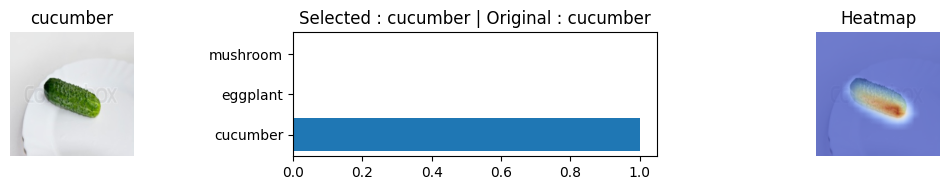

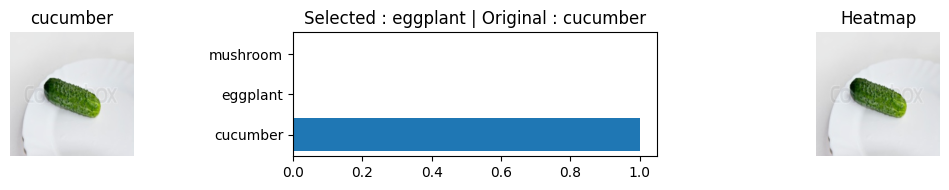

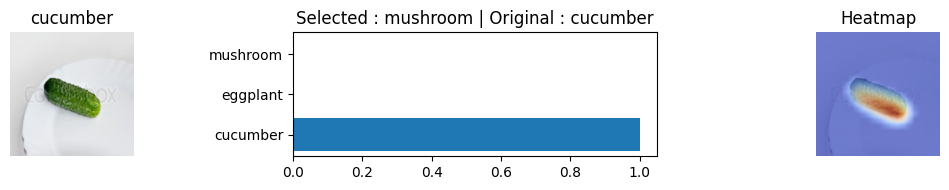

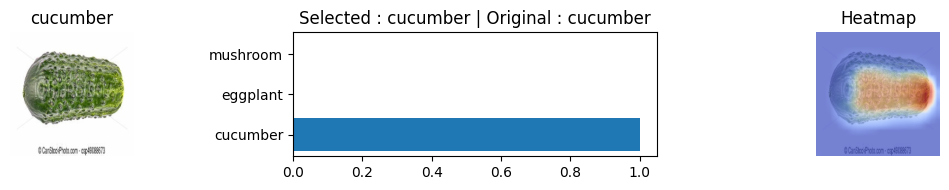

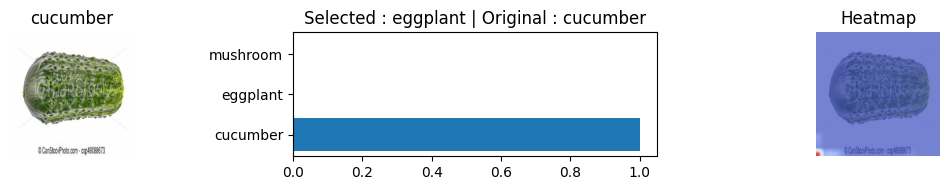

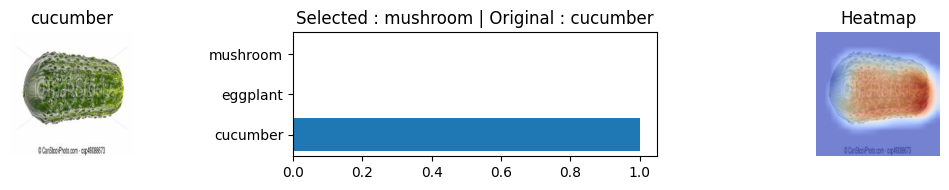

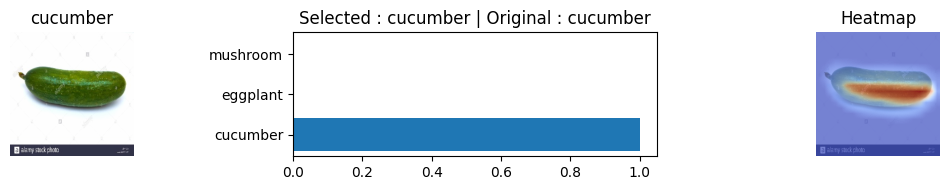

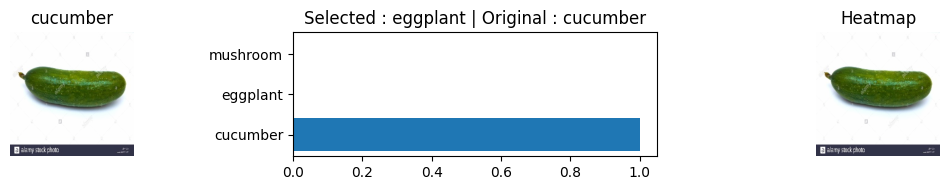

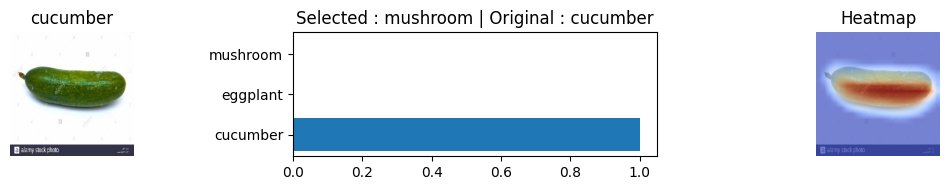

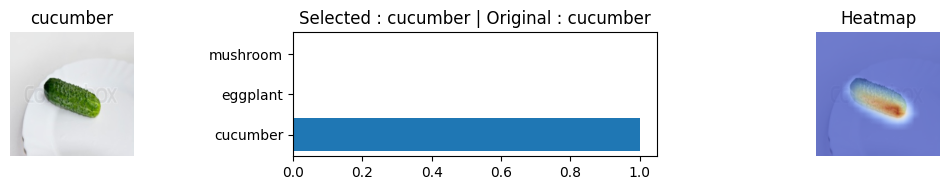

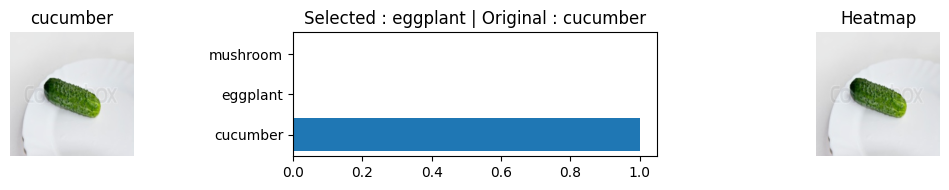

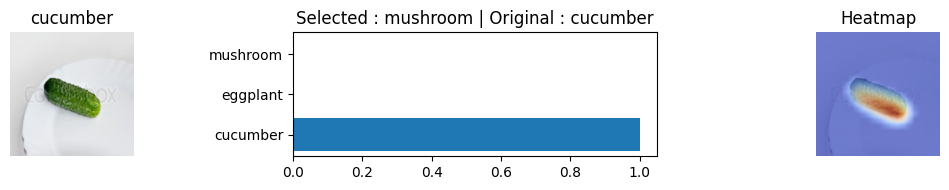

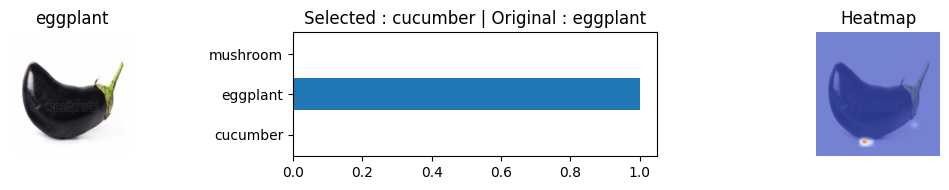

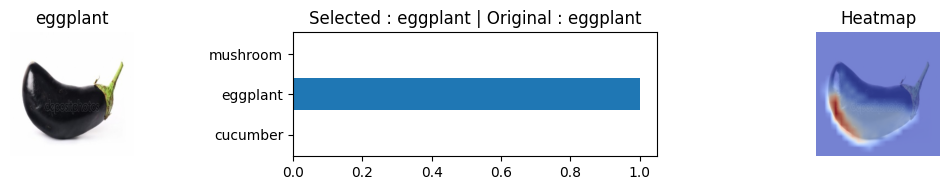

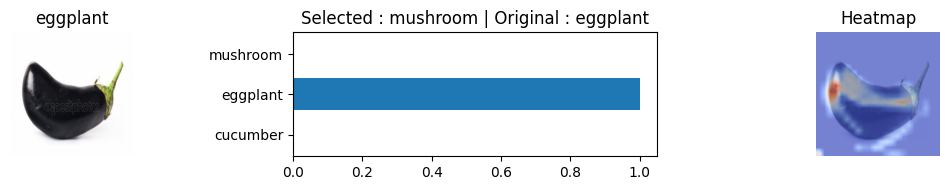

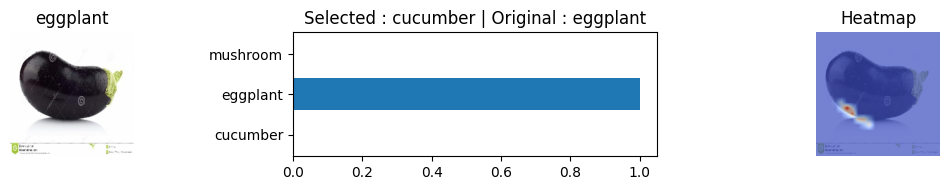

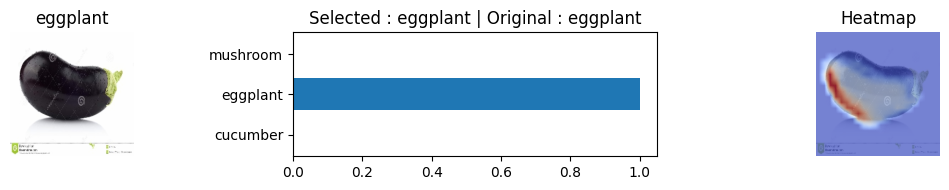

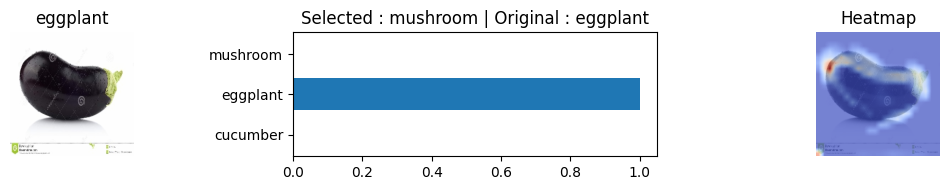

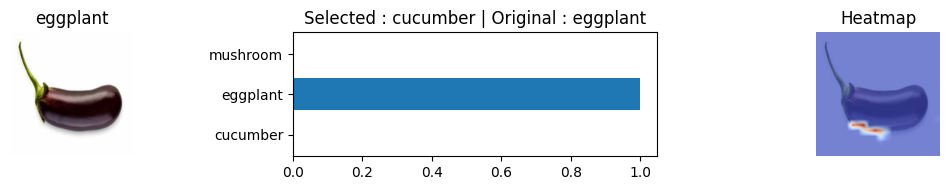

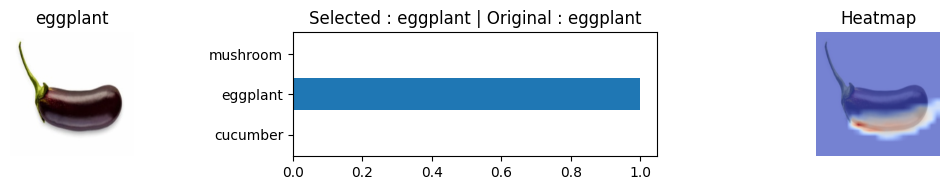

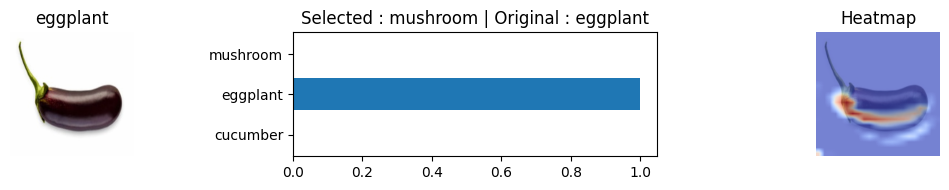

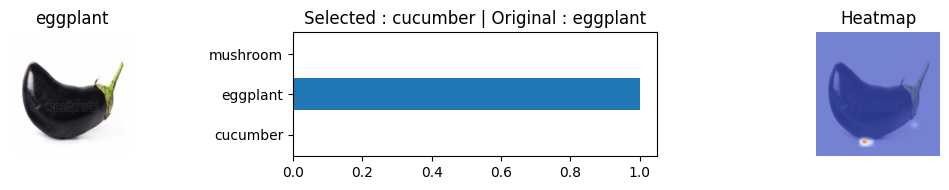

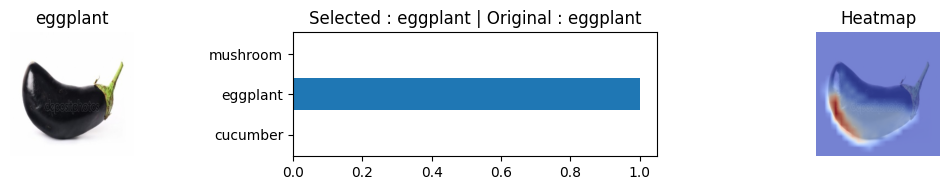

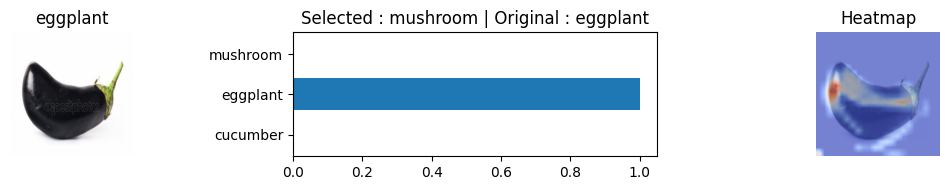

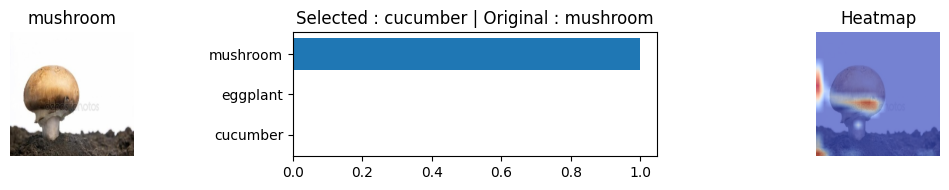

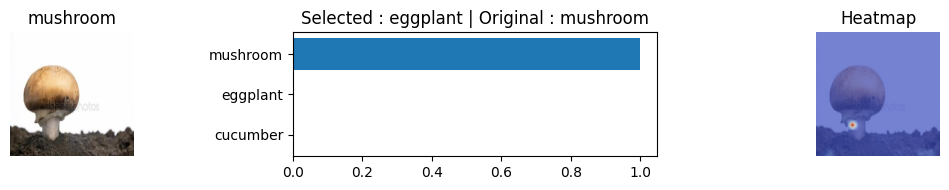

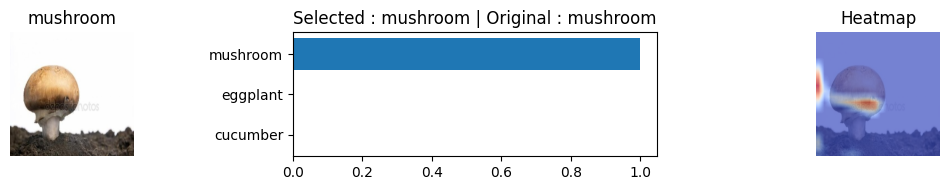

In [27]:
all_class = list(label_class.values())
rand_idx = torch.randint(0,len(validset),size=[10])
for idx in rand_idx:
    image,label = validset[idx.item()]
    denorm_img = image.permute(1,2,0)*np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406])
    image = image.unsqueeze(0).to(device)
    
    for class_ in all_class:
        pred = mymodel(image)
        class_pred = pred[0][class_label[class_]]
        heatmap = grad_Cam(mymodel,image,class_pred,size=227)
        plot_results(denorm_img,label_class,pred,heatmap,class_)